In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)[0:12]

train_path = "../split_datasets/train/"
test_path = "../split_datasets/test/"
val_path = "../split_datasets/validation/"

train_files = get_file_names(train_path)
test_files = get_file_names(test_path)
val_files = get_file_names(val_path)

frames = []
for i in train_files:
    frames.append(pd.read_csv(train_path+i)[0:100])
    break
train_df = pd.concat(frames, sort=False)
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.fillna(0)

frames = []
for i in test_files:
    frames.append(pd.read_csv(test_path+i))
    break
test_df = pd.concat(frames, sort=False)
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.fillna(0)

frames = []
for i in val_files:
    frames.append(pd.read_csv(val_path+i)[0:100])
    break
val_df = pd.concat(frames, sort=False)
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.fillna(0)

min_price = min(train_df['price'].min(), test_df['price'].min(), val_df['price'].min())
max_price = max(train_df['price'].max(), test_df['price'].max(), val_df['price'].max())
#min_long = min(train_df['longitude'].min(), test_df['longitude'].min(), val_df['longitude'].min())
#max_long = max(train_df['longitude'].max(), test_df['longitude'].max(), val_df['longitude'].max())
min_lat = min(train_df['latitude'].min(), test_df['latitude'].min(), val_df['latitude'].min())
max_lat = max(train_df['latitude'].max(), test_df['latitude'].max(), val_df['latitude'].max())

train_df['price'] = (train_df['price'] - min_price)/(max_price - min_price)
#train_df['longitude'] = (train_df['longitude'] - min_long)/(max_long - min_long)
train_df['latitude'] = (train_df['latitude'] - min_lat)/(max_lat - min_lat)
train_df = train_df.reset_index(drop=True)

test_df['price'] = (test_df['price'] - min_price)/(max_price - min_price)
#test_df['longitude'] = (test_df['longitude'] - min_long)/(max_long - min_long)
test_df['latitude'] = (test_df['latitude'] - min_lat)/(max_lat - min_lat)
test_df = test_df.reset_index(drop=True)

val_df['price'] = (val_df['price'] - min_price)/(max_price - min_price)
#val_df['longitude'] = (val_df['longitude'] - min_long)/(max_long - min_long)
val_df['latitude'] = (val_df['latitude'] - min_lat)/(max_lat - min_lat)
val_df = val_df.reset_index(drop=True)
#train_df = train_df.drop(columns=["minimum_nights", "maximum_nights"])
#test_df = test_df.drop(columns=["minimum_nights", "maximum_nights"])
#val_df = val_df.drop(columns=["minimum_nights", "maximum_nights"])

#print(minimum, maximum)
bounds = [min_price, max_price]

In [3]:
train_df.head(5)

,latitude,accommodates,bathrooms,bedrooms,beds,price,amenities_TV,amenities_Air conditioning,amenities_Kitchen,amenities_Indoor fireplace,...,property_type_House,property_type_Loft,property_type_Serviced apartment,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_strict_14_with_grace_period
0,0.295877,2,1.0,0.0,2.0,0.047923,1,1,1,0,...,0,1,0,1,0,0,1,0,1,0
1,0.308621,2,1.0,1.0,2.0,0.348243,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
2,0.441983,3,1.0,1.0,2.0,0.303514,1,1,1,1,...,0,0,0,1,0,0,1,0,1,0
3,0.730529,2,1.0,1.0,1.0,0.204473,1,1,1,0,...,1,0,0,1,0,0,0,1,1,0
4,0.268638,4,1.5,1.0,1.0,0.316294,1,1,1,0,...,0,0,0,1,0,0,1,0,0,0


In [4]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(self.df.iloc[index]).float()
        label = torch.tensor([self.price.iloc[index]]).float()
        return {"sample": sample, "label": label}

In [5]:
train_ds = airbnb_dataset(train_df, "train")
test_ds = airbnb_dataset(test_df, "test")
val_ds = airbnb_dataset(val_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False, num_workers=0)

In [7]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(66, 132)
        self.layer2 = nn.Linear(132, 132)
        self.layer3 = nn.Linear(132, 66)
        self.layer4 = nn.Linear(66, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

In [8]:
def train(net, train_loader, val_loader, bounds, folder, lr, num_epoch):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum = 0.9)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"]
            label = data["label"]
            output = net(sample)
            loss = criterion(output, label)
            #print(label, output)
            #print(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30], bounds)
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    

def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    #plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        #plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()
    
    
    return None

In [9]:
def get_error(model, train_loader, val_loader, threshold, bounds):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)*(bounds[1]-bounds[0])
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)*(bounds[1]-bounds[0])
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

In [10]:
net = airbnb_net()

Starting Training...
[EPOCH 1] loss: 0.050966  time: 0.116
[EPOCH 2] loss: 0.038601  time: 0.209
[EPOCH 3] loss: 0.028319  time: 0.233
[EPOCH 4] loss: 0.029912  time: 0.228
[EPOCH 5] loss: 0.037761  time: 0.228
[EPOCH 6] loss: 0.039094  time: 0.219
[EPOCH 7] loss: 0.031698  time: 0.216
[EPOCH 8] loss: 0.024910  time: 0.211
[EPOCH 9] loss: 0.025045  time: 0.217
[EPOCH 10] loss: 0.028861  time: 0.697


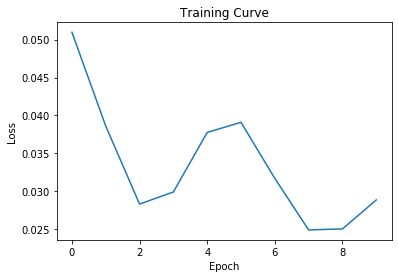

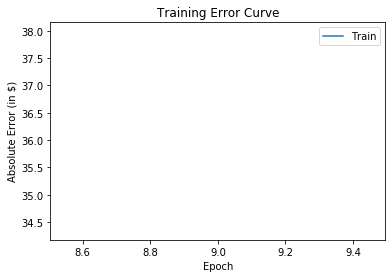

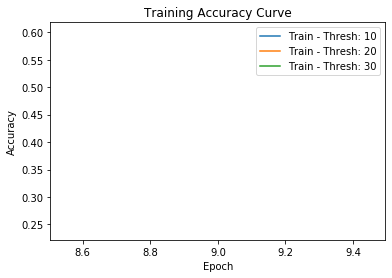

[EPOCH 11] loss: 0.029775  time: 0.166
[EPOCH 12] loss: 0.025651  time: 0.188
[EPOCH 13] loss: 0.020579  time: 0.233
[EPOCH 14] loss: 0.019680  time: 0.261
[EPOCH 15] loss: 0.022337  time: 0.262
[EPOCH 16] loss: 0.022630  time: 0.262
[EPOCH 17] loss: 0.018660  time: 0.258
[EPOCH 18] loss: 0.015695  time: 0.267
[EPOCH 19] loss: 0.016657  time: 0.335
[EPOCH 20] loss: 0.017848  time: 0.644


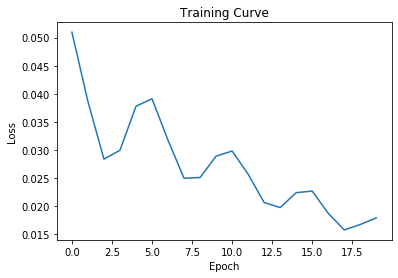

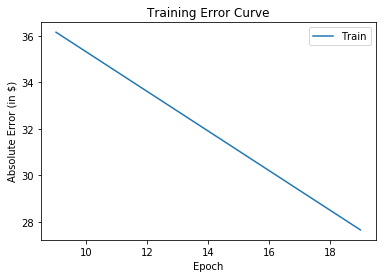

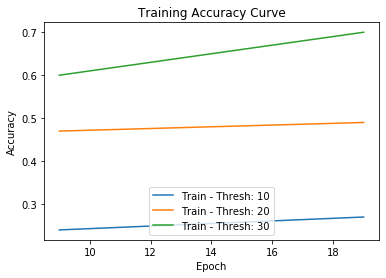

[EPOCH 21] loss: 0.015792  time: 0.164
[EPOCH 22] loss: 0.013041  time: 0.233
[EPOCH 23] loss: 0.013635  time: 0.255
[EPOCH 24] loss: 0.014960  time: 0.278
[EPOCH 25] loss: 0.013039  time: 0.264
[EPOCH 26] loss: 0.011532  time: 0.299
[EPOCH 27] loss: 0.012802  time: 0.187
[EPOCH 28] loss: 0.012965  time: 0.312
[EPOCH 29] loss: 0.011185  time: 0.245
[EPOCH 30] loss: 0.011090  time: 0.558


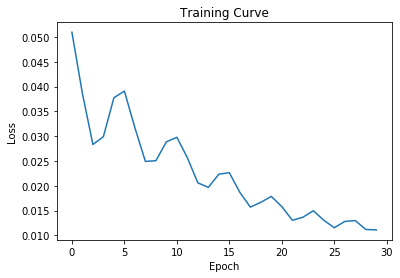

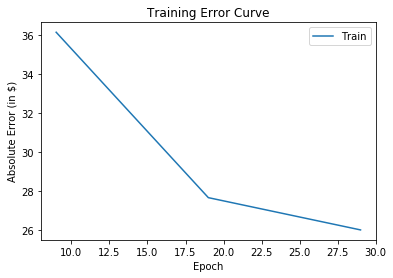

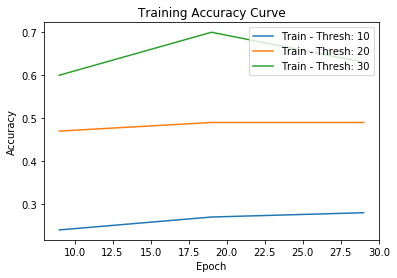

[EPOCH 31] loss: 0.011941  time: 0.123
[EPOCH 32] loss: 0.010774  time: 0.320
[EPOCH 33] loss: 0.009961  time: 0.285
[EPOCH 34] loss: 0.010558  time: 0.308
[EPOCH 35] loss: 0.010116  time: 0.304
[EPOCH 36] loss: 0.009087  time: 0.315
[EPOCH 37] loss: 0.009247  time: 0.242
[EPOCH 38] loss: 0.009332  time: 0.233
[EPOCH 39] loss: 0.008548  time: 0.226
[EPOCH 40] loss: 0.008375  time: 0.708


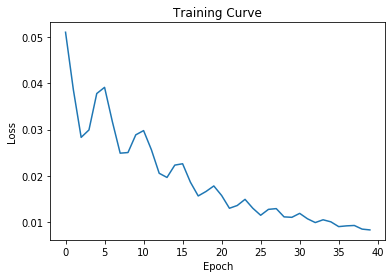

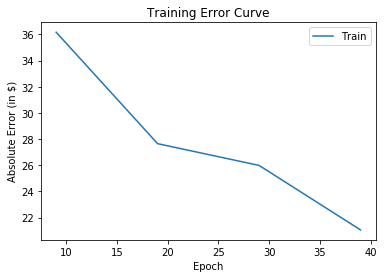

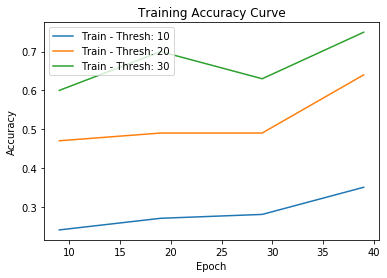

[EPOCH 41] loss: 0.008619  time: 0.119
[EPOCH 42] loss: 0.008231  time: 0.211
[EPOCH 43] loss: 0.007832  time: 0.336
[EPOCH 44] loss: 0.007981  time: 0.293
[EPOCH 45] loss: 0.007846  time: 0.221
[EPOCH 46] loss: 0.007405  time: 0.213
[EPOCH 47] loss: 0.007368  time: 0.214
[EPOCH 48] loss: 0.007339  time: 0.231
[EPOCH 49] loss: 0.006969  time: 0.230
[EPOCH 50] loss: 0.006799  time: 0.596


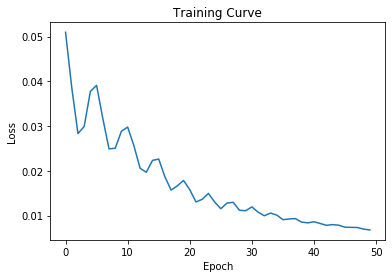

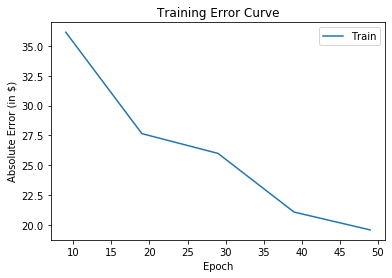

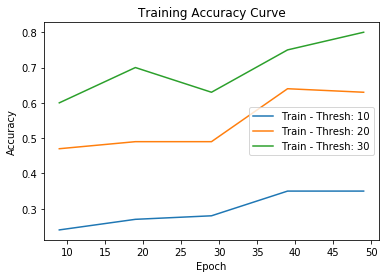

[EPOCH 51] loss: 0.006796  time: 0.119
[EPOCH 52] loss: 0.006522  time: 0.209
[EPOCH 53] loss: 0.006311  time: 0.209
[EPOCH 54] loss: 0.006293  time: 0.207
[EPOCH 55] loss: 0.006100  time: 0.204
[EPOCH 56] loss: 0.005893  time: 0.272
[EPOCH 57] loss: 0.005853  time: 0.287
[EPOCH 58] loss: 0.005696  time: 0.286
[EPOCH 59] loss: 0.005495  time: 0.228
[EPOCH 60] loss: 0.005429  time: 0.640


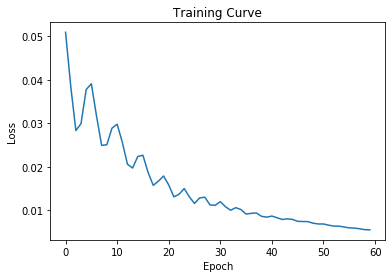

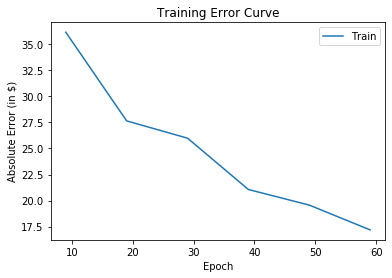

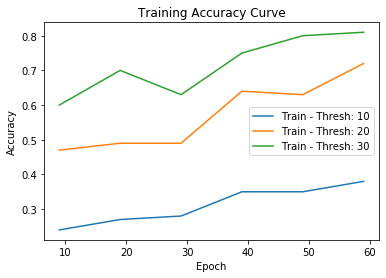

[EPOCH 61] loss: 0.005279  time: 0.125
[EPOCH 62] loss: 0.005093  time: 0.258
[EPOCH 63] loss: 0.005014  time: 0.253
[EPOCH 64] loss: 0.004875  time: 0.233
[EPOCH 65] loss: 0.004714  time: 0.248
[EPOCH 66] loss: 0.004628  time: 0.294
[EPOCH 67] loss: 0.004496  time: 0.355
[EPOCH 68] loss: 0.004353  time: 0.341
[EPOCH 69] loss: 0.004264  time: 0.298
[EPOCH 70] loss: 0.004134  time: 0.587


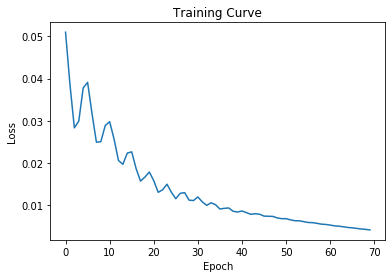

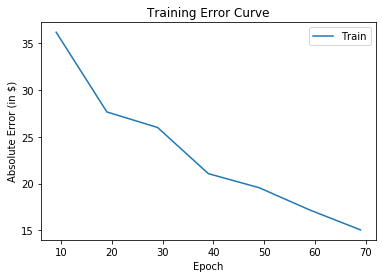

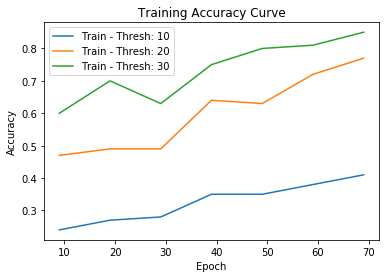

[EPOCH 71] loss: 0.004005  time: 0.124
[EPOCH 72] loss: 0.003911  time: 0.266
[EPOCH 73] loss: 0.003782  time: 0.249
[EPOCH 74] loss: 0.003664  time: 0.220
[EPOCH 75] loss: 0.003567  time: 0.218
[EPOCH 76] loss: 0.003444  time: 0.317
[EPOCH 77] loss: 0.003342  time: 0.331
[EPOCH 78] loss: 0.003247  time: 0.338
[EPOCH 79] loss: 0.003137  time: 0.226
[EPOCH 80] loss: 0.003049  time: 0.561


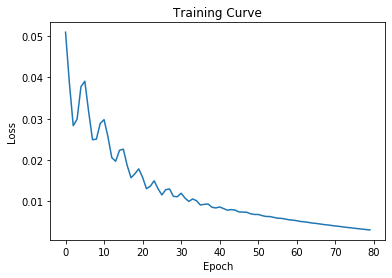

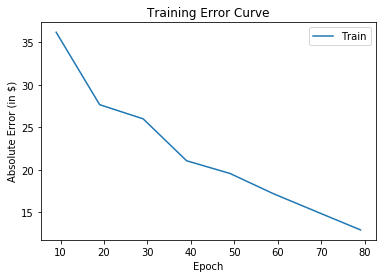

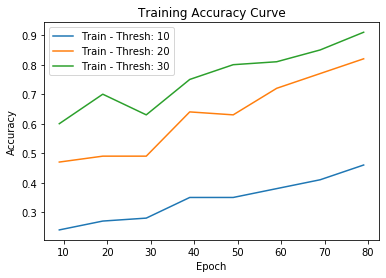

[EPOCH 81] loss: 0.002958  time: 0.141
[EPOCH 82] loss: 0.002863  time: 0.235
[EPOCH 83] loss: 0.002786  time: 0.230
[EPOCH 84] loss: 0.002701  time: 0.231
[EPOCH 85] loss: 0.002622  time: 0.229
[EPOCH 86] loss: 0.002552  time: 0.209
[EPOCH 87] loss: 0.002472  time: 0.207
[EPOCH 88] loss: 0.002402  time: 0.208
[EPOCH 89] loss: 0.002333  time: 0.213
[EPOCH 90] loss: 0.002262  time: 0.701


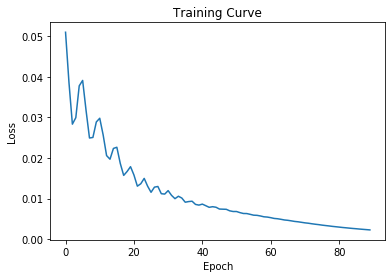

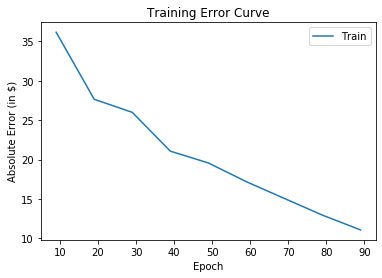

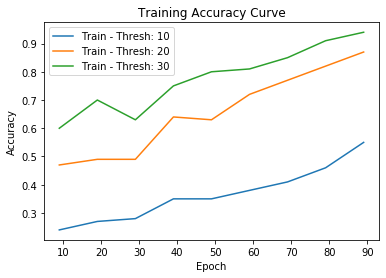

[EPOCH 91] loss: 0.002200  time: 0.111
[EPOCH 92] loss: 0.002133  time: 0.205
[EPOCH 93] loss: 0.002071  time: 0.215
[EPOCH 94] loss: 0.002013  time: 0.213
[EPOCH 95] loss: 0.001951  time: 0.188
[EPOCH 96] loss: 0.001896  time: 0.203
[EPOCH 97] loss: 0.001840  time: 0.192
[EPOCH 98] loss: 0.001786  time: 0.216
[EPOCH 99] loss: 0.001735  time: 0.211
[EPOCH 100] loss: 0.001683  time: 0.648


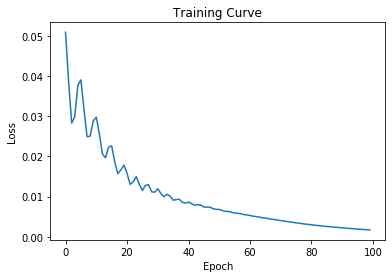

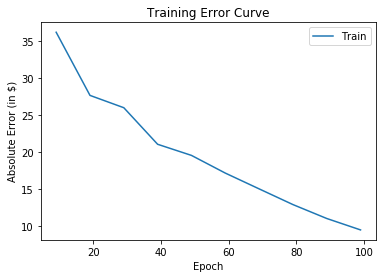

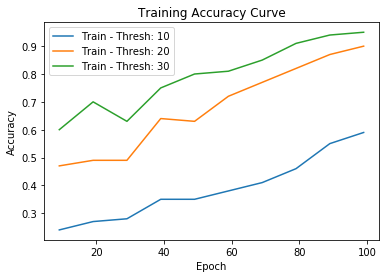

[EPOCH 101] loss: 0.001635  time: 0.104
[EPOCH 102] loss: 0.001586  time: 0.213
[EPOCH 103] loss: 0.001540  time: 0.300
[EPOCH 104] loss: 0.001494  time: 0.307
[EPOCH 105] loss: 0.001450  time: 0.234
[EPOCH 106] loss: 0.001408  time: 0.213
[EPOCH 107] loss: 0.001365  time: 0.210
[EPOCH 108] loss: 0.001326  time: 0.211
[EPOCH 109] loss: 0.001286  time: 0.215
[EPOCH 110] loss: 0.001248  time: 0.526


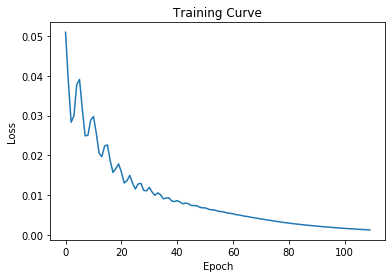

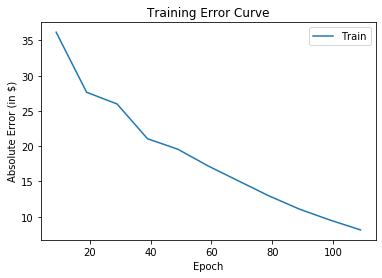

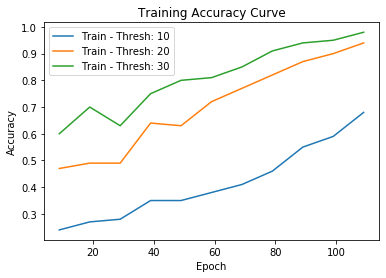

[EPOCH 111] loss: 0.001210  time: 0.193
[EPOCH 112] loss: 0.001172  time: 0.242
[EPOCH 113] loss: 0.001136  time: 0.263
[EPOCH 114] loss: 0.001101  time: 0.257
[EPOCH 115] loss: 0.001067  time: 0.276
[EPOCH 116] loss: 0.001034  time: 0.284
[EPOCH 117] loss: 0.001003  time: 0.287
[EPOCH 118] loss: 0.000973  time: 0.266
[EPOCH 119] loss: 0.000944  time: 0.231
[EPOCH 120] loss: 0.000915  time: 0.749


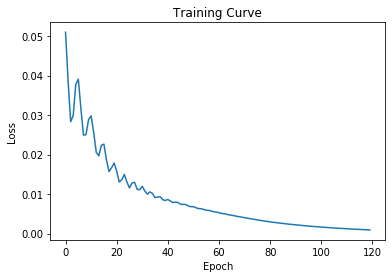

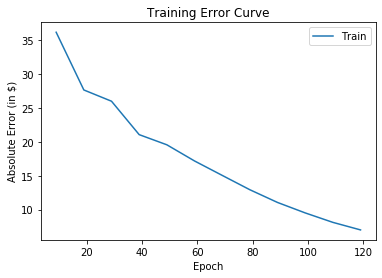

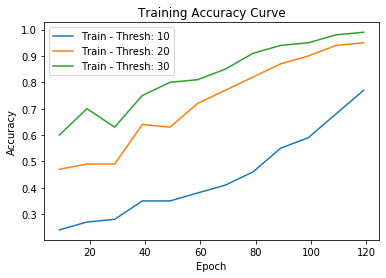

[EPOCH 121] loss: 0.000887  time: 0.115
[EPOCH 122] loss: 0.000860  time: 0.195
[EPOCH 123] loss: 0.000833  time: 0.259
[EPOCH 124] loss: 0.000808  time: 0.275
[EPOCH 125] loss: 0.000783  time: 0.308
[EPOCH 126] loss: 0.000759  time: 0.297
[EPOCH 127] loss: 0.000735  time: 0.237
[EPOCH 128] loss: 0.000712  time: 0.251
[EPOCH 129] loss: 0.000690  time: 0.376
[EPOCH 130] loss: 0.000669  time: 1.116


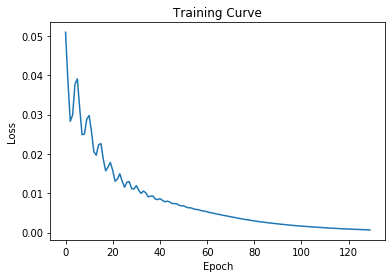

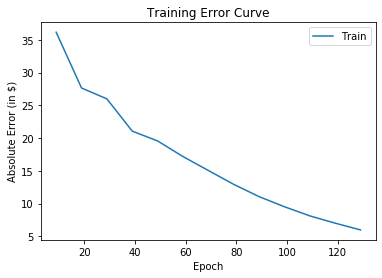

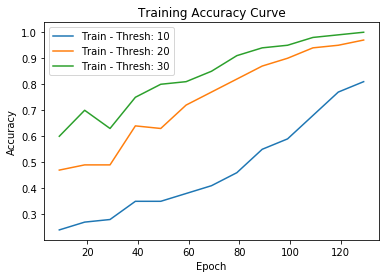

[EPOCH 131] loss: 0.000648  time: 0.145
[EPOCH 132] loss: 0.000629  time: 0.179
[EPOCH 133] loss: 0.000610  time: 0.194
[EPOCH 134] loss: 0.000591  time: 0.205
[EPOCH 135] loss: 0.000573  time: 0.189
[EPOCH 136] loss: 0.000556  time: 0.218
[EPOCH 137] loss: 0.000539  time: 0.212
[EPOCH 138] loss: 0.000523  time: 0.217
[EPOCH 139] loss: 0.000507  time: 0.202
[EPOCH 140] loss: 0.000492  time: 0.530


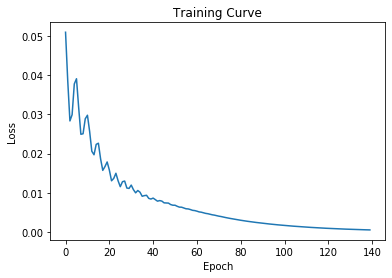

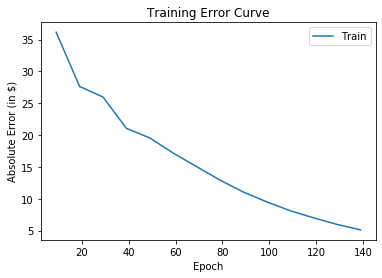

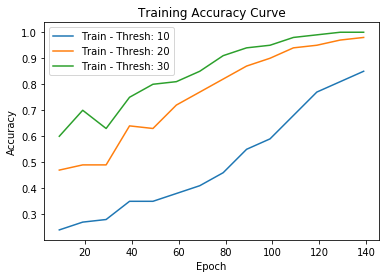

[EPOCH 141] loss: 0.000478  time: 0.112
[EPOCH 142] loss: 0.000463  time: 0.219
[EPOCH 143] loss: 0.000449  time: 0.218
[EPOCH 144] loss: 0.000436  time: 0.216
[EPOCH 145] loss: 0.000423  time: 0.219
[EPOCH 146] loss: 0.000410  time: 0.232
[EPOCH 147] loss: 0.000398  time: 0.236
[EPOCH 148] loss: 0.000386  time: 0.234
[EPOCH 149] loss: 0.000374  time: 0.231
[EPOCH 150] loss: 0.000363  time: 0.600


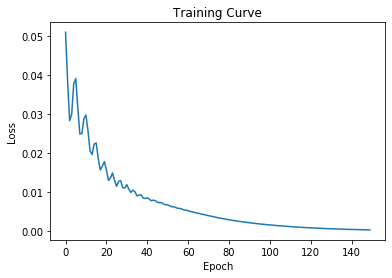

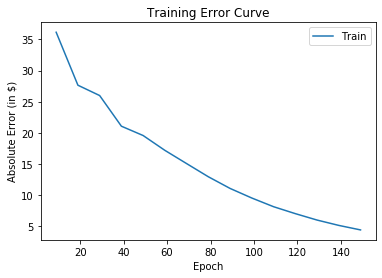

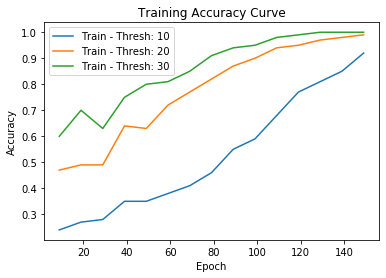

[EPOCH 151] loss: 0.000352  time: 0.112
[EPOCH 152] loss: 0.000341  time: 0.212
[EPOCH 153] loss: 0.000331  time: 0.213
[EPOCH 154] loss: 0.000321  time: 0.216
[EPOCH 155] loss: 0.000312  time: 0.218
[EPOCH 156] loss: 0.000302  time: 0.214
[EPOCH 157] loss: 0.000293  time: 0.216
[EPOCH 158] loss: 0.000285  time: 0.216
[EPOCH 159] loss: 0.000276  time: 0.213
[EPOCH 160] loss: 0.000268  time: 0.530


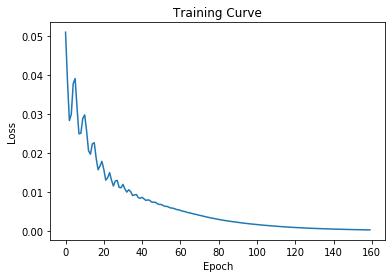

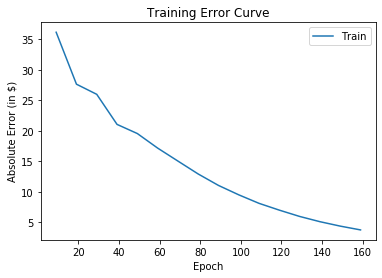

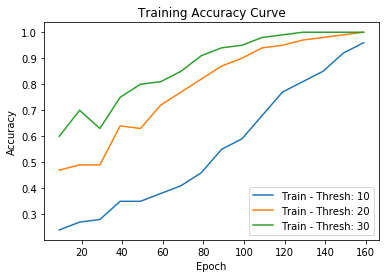

[EPOCH 161] loss: 0.000260  time: 0.126
[EPOCH 162] loss: 0.000252  time: 0.216
[EPOCH 163] loss: 0.000245  time: 0.204
[EPOCH 164] loss: 0.000238  time: 0.198
[EPOCH 165] loss: 0.000231  time: 0.203
[EPOCH 166] loss: 0.000224  time: 0.198
[EPOCH 167] loss: 0.000217  time: 0.208
[EPOCH 168] loss: 0.000211  time: 0.195
[EPOCH 169] loss: 0.000205  time: 0.213
[EPOCH 170] loss: 0.000199  time: 0.510


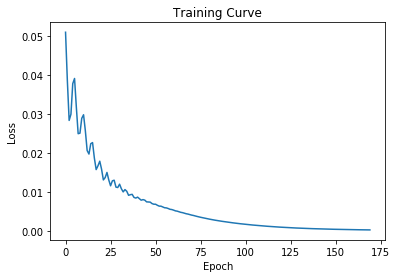

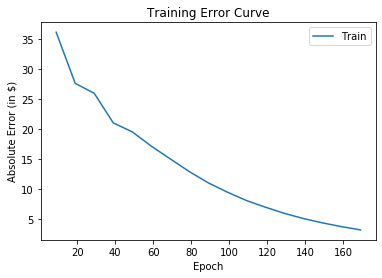

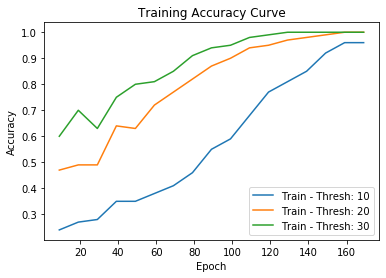

[EPOCH 171] loss: 0.000193  time: 0.119
[EPOCH 172] loss: 0.000187  time: 0.216
[EPOCH 173] loss: 0.000182  time: 0.202
[EPOCH 174] loss: 0.000177  time: 0.214
[EPOCH 175] loss: 0.000172  time: 0.209
[EPOCH 176] loss: 0.000167  time: 0.234
[EPOCH 177] loss: 0.000162  time: 0.228
[EPOCH 178] loss: 0.000157  time: 0.228
[EPOCH 179] loss: 0.000153  time: 0.225
[EPOCH 180] loss: 0.000148  time: 0.562


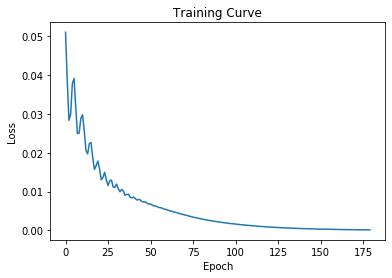

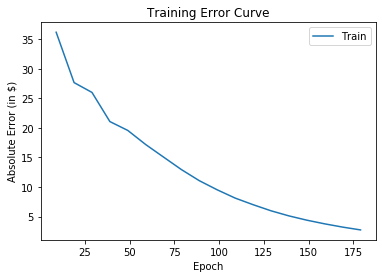

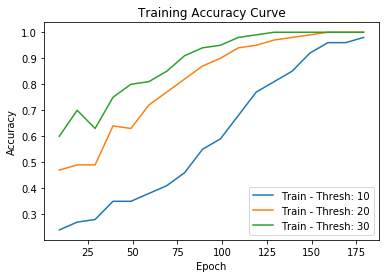

[EPOCH 181] loss: 0.000144  time: 0.139
[EPOCH 182] loss: 0.000140  time: 0.210
[EPOCH 183] loss: 0.000136  time: 0.209
[EPOCH 184] loss: 0.000132  time: 0.217
[EPOCH 185] loss: 0.000128  time: 0.213
[EPOCH 186] loss: 0.000124  time: 0.214
[EPOCH 187] loss: 0.000121  time: 0.206
[EPOCH 188] loss: 0.000117  time: 0.204
[EPOCH 189] loss: 0.000114  time: 0.216
[EPOCH 190] loss: 0.000111  time: 0.512


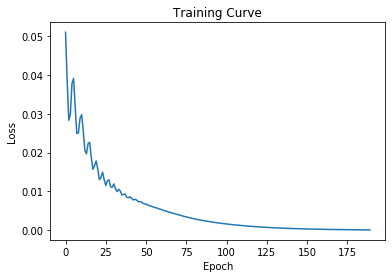

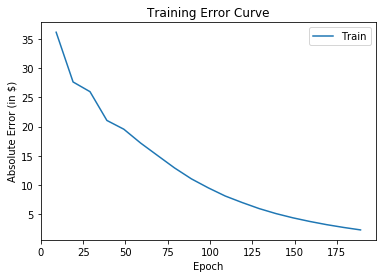

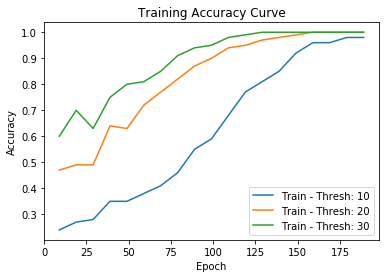

[EPOCH 191] loss: 0.000108  time: 0.195
[EPOCH 192] loss: 0.000105  time: 0.312
[EPOCH 193] loss: 0.000102  time: 0.292
[EPOCH 194] loss: 0.000099  time: 0.279
[EPOCH 195] loss: 0.000096  time: 0.267
[EPOCH 196] loss: 0.000093  time: 0.303
[EPOCH 197] loss: 0.000091  time: 0.278
[EPOCH 198] loss: 0.000088  time: 0.277
[EPOCH 199] loss: 0.000086  time: 0.292
[EPOCH 200] loss: 0.000084  time: 0.617


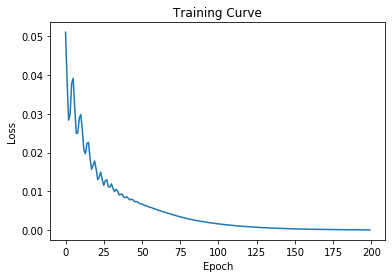

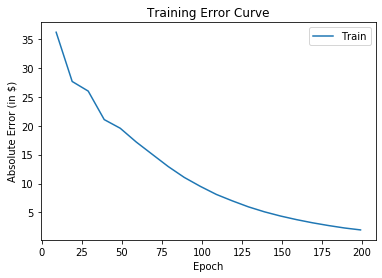

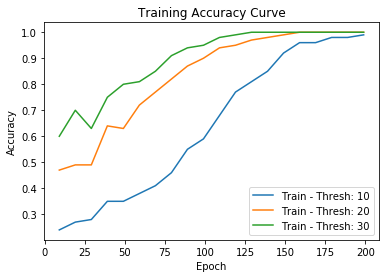

[EPOCH 201] loss: 0.000081  time: 0.188
[EPOCH 202] loss: 0.000079  time: 0.315
[EPOCH 203] loss: 0.000077  time: 0.250
[EPOCH 204] loss: 0.000075  time: 0.291
[EPOCH 205] loss: 0.000073  time: 0.274
[EPOCH 206] loss: 0.000071  time: 0.265
[EPOCH 207] loss: 0.000069  time: 0.299
[EPOCH 208] loss: 0.000067  time: 0.292
[EPOCH 209] loss: 0.000065  time: 0.287
[EPOCH 210] loss: 0.000064  time: 0.837


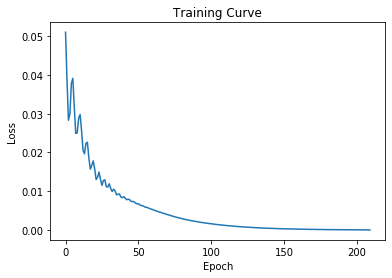

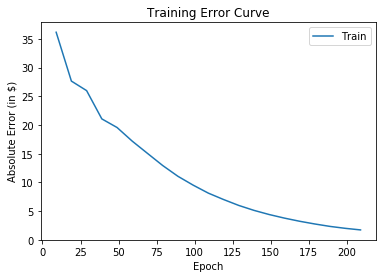

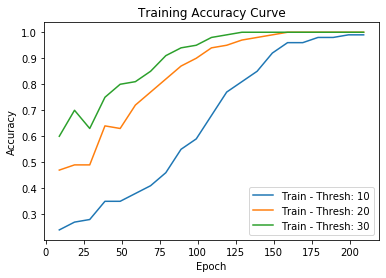

[EPOCH 211] loss: 0.000062  time: 0.214
[EPOCH 212] loss: 0.000060  time: 0.250
[EPOCH 213] loss: 0.000059  time: 0.271
[EPOCH 214] loss: 0.000057  time: 0.220
[EPOCH 215] loss: 0.000056  time: 0.235
[EPOCH 216] loss: 0.000054  time: 0.284
[EPOCH 217] loss: 0.000053  time: 0.266
[EPOCH 218] loss: 0.000051  time: 0.241
[EPOCH 219] loss: 0.000050  time: 0.249
[EPOCH 220] loss: 0.000049  time: 0.865


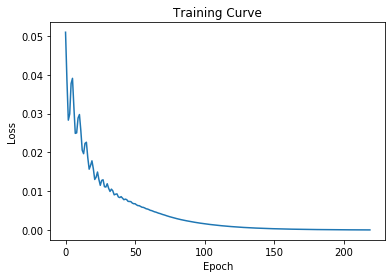

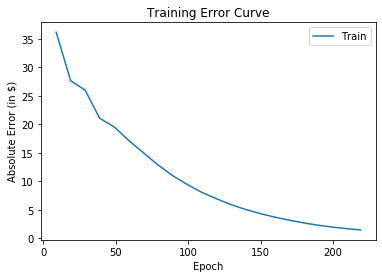

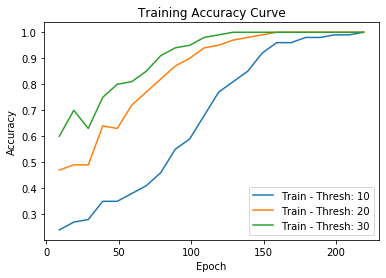

[EPOCH 221] loss: 0.000047  time: 0.209
[EPOCH 222] loss: 0.000046  time: 0.330
[EPOCH 223] loss: 0.000045  time: 0.290
[EPOCH 224] loss: 0.000044  time: 0.290
[EPOCH 225] loss: 0.000043  time: 0.232
[EPOCH 226] loss: 0.000041  time: 0.257
[EPOCH 227] loss: 0.000040  time: 0.233
[EPOCH 228] loss: 0.000039  time: 0.308
[EPOCH 229] loss: 0.000038  time: 0.278
[EPOCH 230] loss: 0.000037  time: 0.614


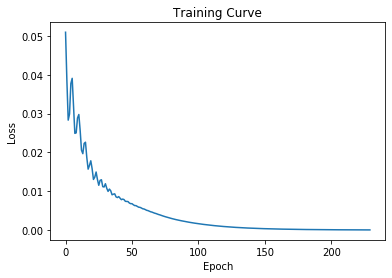

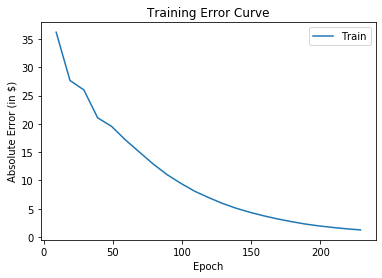

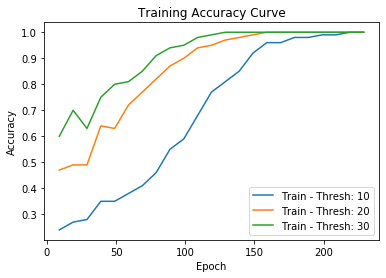

[EPOCH 231] loss: 0.000036  time: 0.156
[EPOCH 232] loss: 0.000035  time: 0.238
[EPOCH 233] loss: 0.000034  time: 0.250
[EPOCH 234] loss: 0.000033  time: 0.357
[EPOCH 235] loss: 0.000032  time: 0.335
[EPOCH 236] loss: 0.000031  time: 0.334
[EPOCH 237] loss: 0.000030  time: 0.351
[EPOCH 238] loss: 0.000030  time: 0.327
[EPOCH 239] loss: 0.000029  time: 0.265
[EPOCH 240] loss: 0.000028  time: 0.789


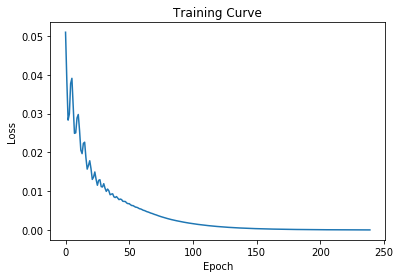

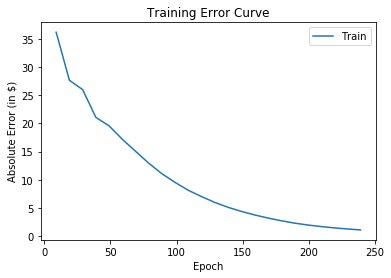

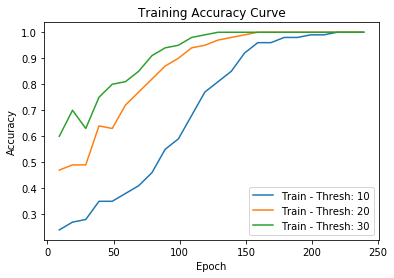

[EPOCH 241] loss: 0.000027  time: 0.163
[EPOCH 242] loss: 0.000026  time: 0.242
[EPOCH 243] loss: 0.000026  time: 0.289
[EPOCH 244] loss: 0.000025  time: 0.287
[EPOCH 245] loss: 0.000024  time: 0.298
[EPOCH 246] loss: 0.000024  time: 0.253
[EPOCH 247] loss: 0.000023  time: 0.225
[EPOCH 248] loss: 0.000022  time: 0.224
[EPOCH 249] loss: 0.000022  time: 0.226
[EPOCH 250] loss: 0.000021  time: 0.796


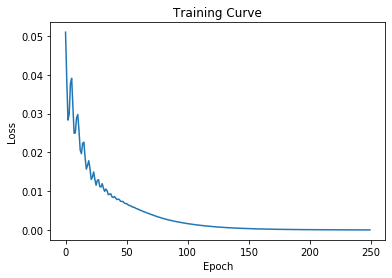

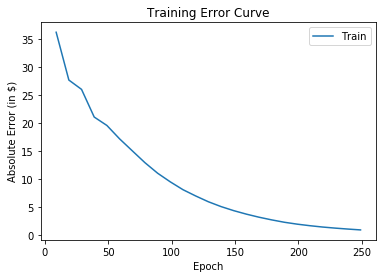

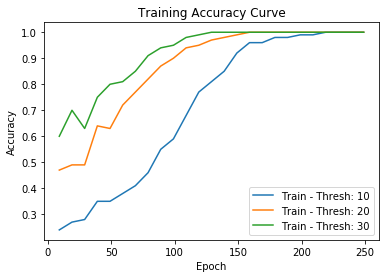

Training Completed...
[FINAL] loss: 0.000021  time: 92.891


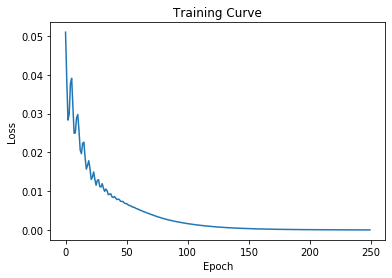

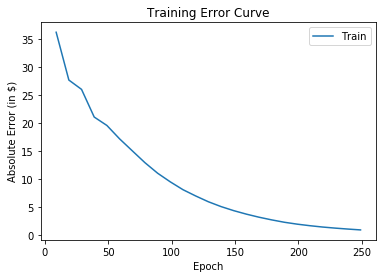

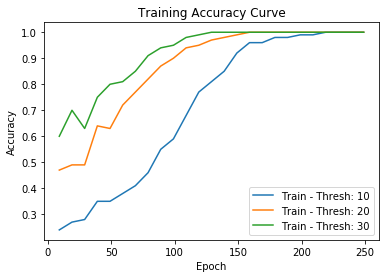

In [17]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Aditi/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

#train(net, train_loader, val_loader, [minimum, maximum], rootdir)

train(net, train_loader, val_loader, [min_price, max_price], rootdir, lr = 0.1, num_epoch = 250)

In [43]:
print(get_error(net, train_loader, val_loader, [10, 20, 30], [min_price, max_price]))

(49.69295288085937, [0.08, 0.17, 0.26], 60.44763545989991, [0.07, 0.13, 0.21])


In [54]:
accum = 0
accum1 = 0
for i in range(100):
    error = net(train_ds[i]["sample"]).item() - train_ds[i]["label"].item()
    accum += error
    accum1 += abs(error)
    print(net(train_ds[i]["sample"]).item(), train_ds[i]["label"].item(), error)
print("Error:", accum/100)

print("Abs Error:", accum1/100*(bounds[1]-bounds[0]))

0.4214916527271271 0.21405750513076782 0.20743414759635925
0.5276427268981934 0.3258785903453827 0.20176413655281067
0.2150266170501709 0.1405750811100006 0.07445153594017029
0.23273341357707977 0.03194888308644295 0.20078453049063683
0.09710259735584259 0.23642171919345856 -0.13931912183761597
0.41814690828323364 0.36421725153923035 0.053929656744003296
0.31207364797592163 0.2044728398323059 0.10760080814361572
0.1313839703798294 0.2651757299900055 -0.1337917596101761
0.08688503503799438 0.01277955248951912 0.07410548254847527
0.05793289840221405 0.028753994032740593 0.029178904369473457
0.31027013063430786 0.36421725153923035 -0.053947120904922485
0.3767816424369812 0.2843450605869293 0.09243658185005188
0.2956864833831787 0.2747603952884674 0.020926088094711304
0.20870961248874664 0.2044728398323059 0.004236772656440735
0.28128132224082947 0.1405750811100006 0.14070624113082886
0.2540990710258484 0.23642171919345856 0.01767735183238983
0.12372308224439621 0.04472843557596207 0.07899

In [ ]:
for i, data in enumerate(train_loader):
    print(len(data["label"]))
    break

In [ ]:
train_ds[4]["label"].item()


In [16]:
a = [3, 6, 9]
a = [i/3 for i in a]

In [17]:
a

[1.0, 2.0, 3.0]

In [26]:
[[], []]

[[], []]

4